In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image
from torchvision.utils import save_image
import copy

# Choose variants here:

In [2]:
arch = 'ConvNet64'
num_images = 8
trained_model = False

## System setup:

In [3]:
import inversefed #You need to import this package from the authors source code
setup = inversefed.utils.system_startup()
defs = inversefed.training_strategy('conservative')

loss_fn, trainloader, validloader =  inversefed.construct_dataloaders('CIFAR10', defs)

model, _ = inversefed.construct_model(arch, num_classes=10, num_channels=3)
model.to(**setup)
if trained_model:
    epochs = 120
    file = f'{arch}_{epochs}.pth'
    try:
        model.load_state_dict(torch.load(f'models/{file}'))
    except FileNotFoundError:
        inversefed.train(model, loss_fn, trainloader, validloader, defs,setup=setup)
        torch.save(model.state_dict(), f'models/{file}')
model.eval();

Currently evaluating -------------------------------:
Tuesday, 04. May 2021 12:07PM
CPUs: 6, GPUs: 1 on GROGU.
GPU : GeForce RTX 2060
Files already downloaded and verified
Files already downloaded and verified
Model initialized with random key 1574241079.


In [4]:
# Twos copies of the model for two participants
model1 = copy.deepcopy(model)
model2 = copy.deepcopy(model)

In [5]:
dm = torch.as_tensor(inversefed.consts.cifar10_mean, **setup)[:, None, None]
ds = torch.as_tensor(inversefed.consts.cifar10_std, **setup)[:, None, None]
def plot(tensor):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    if tensor.shape[0] == 1:
        return plt.imshow(tensor[0].permute(1, 2, 0).cpu());
    else:
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(12, tensor.shape[0]*12))
        for i, im in enumerate(tensor):
            axes[i].imshow(im.permute(1, 2,0).cpu());

# Reconstruct

### Build the input (ground-truth) gradient

In [ ]:
#One Image for each participant of the two participants

ground_truth_image = torch.as_tensor(np.array(Image.open("auto.jpg").resize((32, 32), Image.BICUBIC)) / 255, 
                                  **setup)
ground_truth1 = ground_truth_image.permute(2, 0, 1).sub(dm).div(ds).unsqueeze(0).contiguous()
labels1 = torch.as_tensor((1,), device=setup['device'])

idx = 60
img, labels2 = validloader.dataset[idx]
labels2 = torch.as_tensor((labels2,), device=setup['device'])
ground_truth2 = img.to(**setup).unsqueeze(0)

In [6]:
#Batch 8 images for each participant of the two participants

ground_truth1, labels1 = [], []
ground_truth2, labels2 = [], []
idx1 = 25 # choosen randomly ... just whatever you want
idx2 = 35 # choosen randomly ... just whatever you want
while len(labels1) < num_images:
    img, label = validloader.dataset[idx1]
    idx1 += 1
    labels1.append(torch.as_tensor((label,), device=setup['device']))
    ground_truth1.append(img.to(**setup))
    
    img, label = validloader.dataset[idx2]
    idx2 += 1
    labels2.append(torch.as_tensor((label,), device=setup['device']))
    ground_truth2.append(img.to(**setup))
    
ground_truth1 = torch.stack(ground_truth1)
labels1 = torch.cat(labels1)

ground_truth2 = torch.stack(ground_truth2)
labels2 = torch.cat(labels2)

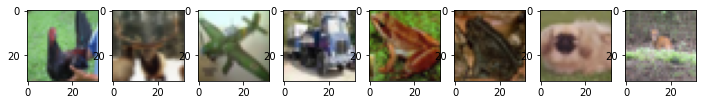

In [7]:
plot(ground_truth1);

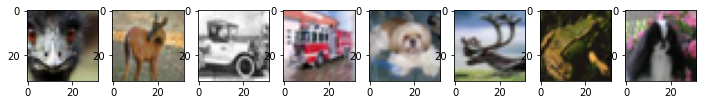

In [8]:
plot(ground_truth2);

In [9]:
local_lr = 1e-4
local_steps = 5
use_updates = True

In [10]:
# Define the reconstruction algorithms
model1.zero_grad()
target_loss, _, _ = loss_fn(model1(ground_truth1), labels1)
input_parameters1 = inversefed.reconstruction_algorithms.loss_steps(model1, ground_truth1, labels1, 
                                                        lr=local_lr, local_steps=local_steps,
                                                                   use_updates=use_updates)
input_parameters1 = [p.detach() for p in input_parameters1]

model2.zero_grad()
target_loss, _, _ = loss_fn(model2(ground_truth2), labels2)
input_parameters2 = inversefed.reconstruction_algorithms.loss_steps(model2, ground_truth2, labels2, 
                                                        lr=local_lr, local_steps=local_steps,
                                                                   use_updates=use_updates)
input_parameters2 = [p.detach() for p in input_parameters2]

In [11]:
#Fragmenting and mixing updates
mixed_parameters1 = []
mixed_parameters2 = []
for param1, param2 in zip(input_parameters1, input_parameters2):
    mask = torch.rand(param1.shape).cuda()
    mask = (mask > 0.5) + 0
    original_part1 = param1*mask
    original_part2 = param2*mask

    exchanged_part1 = param1*(1-mask)
    exchanged_part2 = param2*(1-mask)
    
       
    mixed_parameters1.append(original_part1+exchanged_part2)
    mixed_parameters2.append(original_part2+exchanged_part1)

It: 0. Rec. loss: 0.1732.
It: 500. Rec. loss: 0.1722.
It: 1000. Rec. loss: 0.1720.
It: 1500. Rec. loss: 0.1734.
It: 2000. Rec. loss: 0.1733.
It: 2500. Rec. loss: 0.1724.
It: 3000. Rec. loss: 0.1732.
It: 3500. Rec. loss: 0.1719.
It: 4000. Rec. loss: 0.1726.
It: 4500. Rec. loss: 0.1728.
It: 5000. Rec. loss: 0.1718.
It: 5500. Rec. loss: 0.1724.
It: 6000. Rec. loss: 0.1723.
It: 6500. Rec. loss: 0.1719.
It: 7000. Rec. loss: 0.1726.
It: 7500. Rec. loss: 0.1733.
It: 8000. Rec. loss: 0.1731.
It: 8500. Rec. loss: 0.1713.
It: 9000. Rec. loss: 0.1712.
It: 9500. Rec. loss: 0.1710.
It: 10000. Rec. loss: 0.1698.
It: 10500. Rec. loss: 0.1706.
It: 11000. Rec. loss: 0.1701.
It: 11500. Rec. loss: 0.1702.
It: 12000. Rec. loss: 0.1709.
It: 12500. Rec. loss: 0.1708.
It: 13000. Rec. loss: 0.1711.
It: 13500. Rec. loss: 0.1706.
It: 14000. Rec. loss: 0.1704.
It: 14500. Rec. loss: 0.1696.
It: 15000. Rec. loss: 0.1690.
It: 15500. Rec. loss: 0.1691.
It: 16000. Rec. loss: 0.1687.
It: 16500. Rec. loss: 0.1693.
It: 

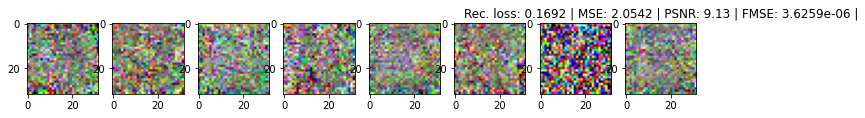

In [12]:
config = dict(signed=True,
              boxed=True,
              cost_fn='sim',
              indices='def',
              weights='equal',
              lr=1,
              optim='adam',
              restarts=1,
              max_iterations=24000,
              total_variation=1e-6,
              init='randn',
              filter='none',
              lr_decay=True,
              scoring_choice='loss')

""" 1.To reconstruct images from the first participant gradient, pass model1 and input_parameters1 
    2. To reconstruct images from the second participant gradient, pass model2 and input_parameters2
    3. To reconstruct images from the first participant mixedgradient, pass model1 and mixed_parameters1
    4. To reconstruct images from the second participant mixedgradient, pass model2 and mixed_parameters2 """
 
rec_machine = inversefed.FedAvgReconstructor(model2, (dm, ds), local_steps, local_lr, config,
                                             use_updates=use_updates, num_images=num_images)
output, stats = rec_machine.reconstruct(mixed_parameters2, labels2, img_shape=(3, 32, 32))

test_mse = (output.detach() - ground_truth2).pow(2).mean()
feat_mse = (model2(output.detach())- model2(ground_truth2)).pow(2).mean()  
test_psnr = inversefed.metrics.psnr(output, ground_truth2, factor=1/ds)

plot(output)
plt.title(f"Rec. loss: {stats['opt']:2.4f} | MSE: {test_mse:2.4f} "
          f"| PSNR: {test_psnr:4.2f} | FMSE: {feat_mse:2.4e} |");

In [14]:
# save results 

results = {
            'dataset': 'cifar10',
            'model': 'convnet64',
            'psnr': np.round(test_psnr, 2),
            'ground_truth': ground_truth2,
            'output': output,
            'data': data
            }
savepath = './results/convnet64UnTrained_batch8_exchanged_peer2.t7'
torch.save(results,savepath)